In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import sys
sys.path.append('/dfs/scratch0/vschen/metal')

In [3]:
import warnings
warnings.filterwarnings('ignore')

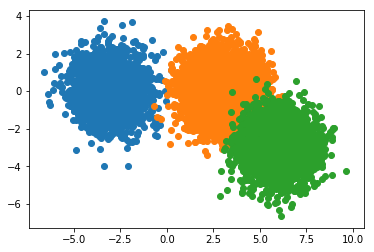

In [4]:
from synthetics_utils import generate_multi_mode_data, generate_label_matrix

# num simulated examples
N = 10000

# mus: [list of d-dim np.arrays] centers of the modes
mus = [
    np.array([-3, 0]), # Mode 1: Y = -1
    np.array([3, 0]), # Mode 2: Y = 1
    np.array([6, -3]) # Mode 3: Y = -1
]
# proportion of data in each mode
props = [0.25, 0.5, 0.25]

# class label of each mode
labels = [-1, 1, -1]

X, Y, C = generate_multi_mode_data(N, mus, props, labels, plot=True)

In [5]:

# "simulated" accuracies and coverage of LFs
accs = np.array([0.75, 0.75, 0.75])
covs = np.array([0.9, 0.9, 0.9])

# overlap between primary "torso" LF and "head" LFs
overlap_portion = 0.05

# labeling function generation
L, overlap_idx = generate_label_matrix(N, accs, covs, Y, C, overlap_portion=overlap_portion)

In [6]:
def eval_model(model,X,L,Y,overlap_idx):
    #overall accuracy of the model
    overall_score = model.score(X, Y) 

    #accuracy of the model on the portion each LF covers
    slice_scores = model.score_on_LF_slices(X, Y, L) 
    try: 
        #accuracy of the model on the overlap between head and torso LF
        overlap_scores = model.score_on_LF_slices(X[overlap_idx,:], Y[overlap_idx], L[overlap_idx,:]) 
    except: 
        overlap_scores = [0,0,0] 
    return  [list(slice_scores)+list(overlap_scores)+list([overall_score])][0]

In [7]:
def train_models(X,L, accs):
    """
    Trains baseline, oracle, and attention model
    Args:
        - X: features
        - L: LF matrix
        - accs: [list of floats] accuracies for LFs
    Returns:
        - model_[0,1,2]: trained baseline, oracle, and attention model
    """

    m = np.shape(L)[1] #num LFs
    d = X.shape[1] #num features

    #baseline model, no attention
    model_0 = SliceDPModel(d, LinearModule, m, accs, r=4, rw=False)
    model_0.train(X, L, batch_size=1000, n_epochs=250, lr=0.1, print_every=250)

    #oracle, manual reweighting
    #TODO: currently hardcode weights so LF[-1] has double the weight
    weights = np.ones(m)
    weights[-1] = 2.0
    model_1 = SliceDPModel(d, LinearModule, m, accs, r=4, rw=False, L_weights=weights)
    model_1.train(X, L, batch_size=1000, n_epochs=250, lr=0.1, print_every=250)

    #our model, with attention
    model_2 = SliceDPModel(d, LinearModule, m, accs, r=2, rw=True)
    model_2.train(X, L, batch_size=1000, n_epochs=250, lr=0.1, print_every=250)
    
    return model_0, model_1, model_2

In [8]:
from online_dp import LinearModule, SliceDPModel

model_0_scores = []
model_1_scores = []
model_2_scores = []

#train the models and score the models (I KNOW ITS UGLY)
model_0, model_1, model_2 = train_models(X,L,accs)
for model, m_scores in zip([model_0, model_1, model_2],[model_0_scores, model_1_scores, model_2_scores]):
    a,b,c,d,e,f,g = eval_model(model,X,L,Y,overlap_idx)
    m_scores.append([a,b,c,d,e,f,g])

[Epoch 0] Loss: 11.785
[Epoch 249] Loss: 11.381
Finished Training
[Epoch 0] Loss: 15.896
[Epoch 249] Loss: 15.107
Finished Training
[Epoch 0] Loss: 11.960
[Epoch 249] Loss: 11.518
Finished Training


In [9]:
scores = pd.DataFrame([[model_0_scores[0][i] for i in [0,1,2,5,6]], [model_1_scores[0][i] for i in [0,1,2,5,6]], [model_2_scores[0][i] for i in [0,1,2,5,6]]])
scores.columns = (['LF0_slice', 'LF1_slice', 'LF2_slice', 'LF1+2_overlap', 'Overall'])
scores.index = (['Baseline', 'Manual', 'Ours'])
scores

,LF0_slice,LF1_slice,LF2_slice,LF1+2_overlap,Overall
Baseline,0.996496,0.986768,0.953146,0.949153,0.9818
Manual,0.995182,0.982863,0.952700,0.949153,0.9788
Ours,0.998686,0.927115,0.997769,1.000000,0.9620
